In [ ]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [ ]:
import pandas as pd
import numpy as np

import src.dataset as dataset
import src.config as config 
from src.utils import *
import src.models as models
import src.losses as loss

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [ ]:
if 'google.colab' in str(get_ipython()):
  use_colab = True
  print('Running on CoLab')
else:
  use_colab = False
  print('Not running on CoLab')

In [ ]:
if use_colab:
    # Read file from Colab Notebook
    from google.colab import drive
    drive.mount('/content/drive')
    config.MODEL_WEIGHTS = "/content/drive/My Drive/Colab Notebooks/SKADC1"
    config.IMAGE_PATH = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset/560Mhz_1000h.fits"

In [ ]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes
ska_dataset = dataset.SKADataset(k=3, print_info=False, use_pb=False)

In [ ]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig', 'area_cropped']].describe()

In [ ]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig']].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99,1.])

In [ ]:
show_plot = True
ska_dataset.generate_patches(limit=5, plot_patches=show_plot) # Remember to remove internal return

In [ ]:
ska_dataset.analyze_class_distribution()

In [ ]:
ska_dataset.split_train_val_stratified(random_state=42, val_portion=0.2)

print(len(ska_dataset.train_patch_list))
print(len(ska_dataset.val_patch_list))


In [ ]:
ska_dataset.split_train_val(random_state=42, val_portion=0.2)

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

In [ ]:
print_img(config.TRAIN_PATCHES_FOLDER, '20_16396_16729_20', show_data=True)


In [ ]:
# # Debugging

# train_patch_list = ska_dataset.train_patch_list
# patches_folder_path=config.TRAIN_PATCHES_FOLDER

# train_datagen = prep.get_anchor_gt(patches_folder_path, ['20_16396_16729_20'], backbone, pixel_mean=None)
# image, [y_rpn_cls_true, y_rpn_reg_true], img_data_aug, _, _, patch_id = next(train_datagen)



### Get FRCNN model

In [ ]:
# Choose the feature extraction model
backbone='baseline_16'
# backbone='vgg16'

if backbone=='baseline_16':
    config.resizePatch = True
    config.rpn_stride = 4
    config.num_rois = 16
    # config.anchor_box_scales = [16,32,64] # anchors in the original image size
    config.anchor_box_scales = [6, 8, 12, 16, 24, 32]
    config.resizeFinalDim = 100
    input_shape_1 = config.resizeFinalDim
else:
    config.resizePatch = True
    config.rpn_stride = 16
    config.num_rois = 4
    config.resizeFinalDim = 600
    input_shape_1=config.resizeFinalDim
    config.anchor_box_scales = [32, 64, 128]


config.anchor_num = len(config.anchor_box_ratios)*len(config.anchor_box_scales)
input_shape_2=(None, 4)

print(config.resizePatch)
print(config.rpn_stride)

checkpoint = get_model_last_checkpoint(backbone)
print(f'Model last checkpoint: {checkpoint}')

In [ ]:
rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

### Load weights

In [ ]:
models.load_weigths(rpn_model, detector_model, backbone, resume_train=False, checkpoint=checkpoint)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [ ]:
# Specifically checking backbone weights

# total_model.weights[24:25][0][0][0][0]

In [ ]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    # print(i,j)
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

- errore "Exception: 'a' cannot be empty unless no samples are taken" quando nel sampling ci sono meno di 4 roi
- errore "None type object is not iterable" dovuto al max(IoUs) quando calc_iou torna None, None, None, None
- patch di debug 1550_16376_16779_100
- capire il parametro classifier_regr_std in che modo influenza il training

- provare normalizzazione valori immagini di input
- provare a far passare più roi anzichè 4

In [ ]:
# zzz = np.load(f'{config.TRAIN_PATCHES_FOLDER}/3100_16376_16829_100/3100_16376_16829_100.npy')

# print_img(config.TRAIN_PATCHES_FOLDER, '3100_16376_16829_100')

20_16396_16729_20

In [ ]:
from src.train import *

val_patch_list = None
train_frcnn(rpn_model, detector_model, total_model, ['20_16396_16729_20'], ska_dataset.val_patch_list, ska_dataset.class_list, num_epochs=100, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=False)
# train_frcnn(rpn_model, detector_model, total_model, ska_dataset.train_patch_list, ska_dataset.val_patch_list, ska_dataset.class_list, num_epochs=300, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=True)

In [22]:
total_model.save_weights(f'{config.MODEL_WEIGHTS}/{backbone}/0_frcnn_{backbone}.h5')

# Validation

In [23]:
rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)    

In [24]:
# Models used for mAP eval
cp = '89_frcnn_baseline_16.h5'
models.load_weigths(rpn_model_eval, detector_model_eval, backbone, checkpoint=cp)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [27]:
patch_id = ['20_16396_16729_20']#ska_dataset.train_patch_list#[1:2]
# print(patch_id)
# gt = pd.read_pickle(f'{config.TRAIN_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')
# display(gt['class_label'])

preds, mAP, prec, recall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, patch_id, ska_dataset.class_list, metric_threshold=.5)

(100, 100)
{0: '2_2', 1: '2_3', 2: '1_1', 3: 'bg'}
Predict
rpn_to_roi
[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [2.6819986e-04 7.8464866e-01 2.6819986e-04 2.1481502e-01]
  [2.1651658e-04 7.9029214e-01 2.1651658e-04 2.0927493e-01]
  [2.6819986e-04 7.8464866e-01 2.6819986e-04 2.1481502e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00

In [ ]:
preds

In [ ]:
print(config.patch_dim , float(config.resizeFinalDim))

In [ ]:
print_img(config.TRAIN_PATCHES_FOLDER, '20_16396_16729_20')

In [28]:
anch = pd.read_pickle(f'{config.EVAL_RESULTS}/20_16396_16729_20/20_16396_16729_20.pkl')
display(anch)

,x1s,y1s,x2s,y2s,class,prob
0,17,28,17,28,2_3,1.000000
1,112,-3217284,112,3217409,2_3,1.000000
2,20,36,20,36,2_3,1.000000
3,10,12,11,12,2_3,0.790292
4,17,0,19,0,2_3,0.786895
5,12,18,15,19,2_3,0.784649
6,12,13,16,17,2_3,0.784649
7,12,13,14,15,2_3,0.784649
8,17,0,19,2,2_3,0.784649
9,0,0,0,1,2_3,0.780104


In [29]:
anch['width'] = anch['x2s'] - anch['x1s']
anch['heght'] = anch['y2s'] - anch['y1s']

In [30]:
anch.describe() 

,x1s,y1s,x2s,y2s,prob,width,heght
count,11.000000,1.100000e+01,11.000000,1.100000e+01,11.000000,11.000000,1.100000e+01
mean,22.181818,-2.924695e+05,23.636364,2.925035e+05,0.841267,1.454545,5.849730e+05
std,30.258282,9.700512e+05,29.827077,9.700814e+05,0.102290,1.368476,1.940133e+06
min,0.000000,-3.217284e+06,0.000000,0.000000e+00,0.758052,0.000000,0.000000e+00
25%,12.000000,0.000000e+00,14.500000,1.500000e+00,0.784649,0.000000,0.000000e+00
50%,15.000000,1.200000e+01,17.000000,1.500000e+01,0.784649,2.000000,1.000000e+00
75%,17.000000,1.550000e+01,19.000000,2.350000e+01,0.895146,2.000000,2.000000e+00
max,112.000000,3.600000e+01,112.000000,3.217409e+06,1.000000,4.000000,6.434693e+06


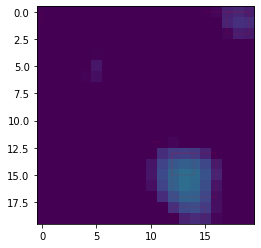

In [31]:
print_img(config.TRAIN_PATCHES_FOLDER, '20_16396_16729_20', config.EVAL_RESULTS)

TODO - 20210508:
- [X] troncamento rumore a 1e-6 tramite half gaussian

TODO - 20210605:
- [X] modificare RPNNet in modo che dia in output anche la backbone - Lorenzo
- [X] scrivere bene training loop: salvare le loss in un df su disco + salvare pesi modello ad ogni giro (Lorenzo - finire di debuggare)

TODO - 20210620:
- [x] implementare mAP in una funzione che prende come parametro un modello o i suoi pesi
- [x] implementare resNet50
- [x] implementare predicted rois - Lorenzo
- [X] implementare plot loss training - Lorenzo
- [X] finire classe datasetv2 - Alice
- [X] check se su colab le performance sono migliori - Lorenzo

TODO - 20210627
- [X] split dataset su combinazioni classi - Alice
- [x] provare campionamento random patch ed osservare le due distribuzioni - Alice

TODO - 20210703
- [x] sistemare salvataggio loss training loop - Lorenzo
- [x] Riscalare immagini tra 0-255 - Alice
- [x] capire se passare tre immagini diverse come input
- [x] usare media vgg16 per zero-centering - Alice

TODO - 20210705
- [x] sistemare nomi funzioni dataset per trasformazione rgb

TODO - 20210711
- [x] rifattorizzare classe dataset spostando nel costruttore i metodi che calcolano i suoi attributi - Lorenzo
- [x] chek valori pixel in input per resnet
- [x] fare funzione per plottare le predictions
- [ ] trainare tutto su colab

TODO - 20210714
- [x] ragionare su come scalare le immagini fra 0 e 1, attualmente hanno tanti valori schiacciati a 0 e il massimo su tutto il train a a 0.4

TODO - 20210717
- [ ] Ablation study: provare a rimuovere stage4 nella resnet - se c'è tempo
- [x] Provare con nostra pixel_mean e con vgg16 pixel_mean -> per il momento abbiamo scartato la prima opzione
- [ ] Fare qualche analisi di distribuzione delle classi/dim box del dataset - Alice
- [x] Aggiungere normalizzazione dopo zero centering per resNet50, sulla base del range globale dell'immagine di training
- [ ] Provare pulizia dataset originale sulla base del rumore/flusso - Alice
- [ ] Cambiare nomi di tutto - alla fine
- [x] implementare zero-centering su volare medio RGB delle nostre patch
- [x] Funzione che trova l'ultimo checkpoint in colab prima del load_weights - Lorenzo

TODO - 20210801
- [x] Debuggare training baseline 8 e 16 - L
- [ ] Finire prove pulizia dataseet noise variando k - A

1.  Summary
    - riassunto progetto
2.  Background
    - SoTA + teoria di base
3.  System Description
    - descrizione dei nostri modelli e dei loro componenti (moduli)
4.  Experimental setup and results
    - dataset pre processing
    - training environment
    - metrics
    - results
5.  Results and error analysis
6.  Discussion

# Plotting

In [ ]:
loss_history = np.load(f"./model/{backbone}/loss_history.npy")
print(loss_history.shape)

In [ ]:
loss_history

In [ ]:
plot_loss(loss_history)